In [82]:
import torch
import torchvision

In [83]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [84]:
from pathlib import Path

root = Path("Malaria Detection CNN")
image_path = root / "Real"

image_path

WindowsPath('Malaria Detection CNN/Real')

In [85]:
import os
def walk_through_dir(dir_path):
  '''Walks through dir_path returning its contents'''
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [86]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'Malaria Detection CNN\Real'
There are 2 directories and 0 images in 'Malaria Detection CNN\Real\test'
There are 0 directories and 309 images in 'Malaria Detection CNN\Real\test\Parasitized'
There are 0 directories and 317 images in 'Malaria Detection CNN\Real\test\Uninfected'
There are 2 directories and 0 images in 'Malaria Detection CNN\Real\train'
There are 0 directories and 6570 images in 'Malaria Detection CNN\Real\train\Parasitized'
There are 0 directories and 6582 images in 'Malaria Detection CNN\Real\train\Uninfected'


## Create DataLoaders and Transform

In [87]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

image_path = root / "training"
# Get amount of cores you cpu can use
NUM_WORKERS = os.cpu_count()

# Create Transforms for model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    normalize
])

# Create dataloaders

# Directories
train_dir = image_path / "train"
test_dir = image_path / "test" 

# Datasets
train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

# get Class names
class_names = train_data.classes

# Create Dataloaders
train_dataloader = DataLoader(
    train_data,
    batch_size=32, # 32 because 32 is a good number for batches
    shuffle=True, # induces randomness
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_dataloader = DataLoader(
    test_data,
    batch_size=32, # 32 because 32 is a good number for batches
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)


## Getting model with Transfer Learning

In [110]:
# get pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [111]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
# model

In [112]:
from torchinfo import summary

summary(model=model, 
        input_size=(1,3,224,224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [113]:
# Freeze everything except the output layer

for params in model.features.parameters():
    params.requires_grad = False

In [114]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [115]:
# Update the classifier to fit our problem
from torch import nn
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)

In [116]:
summary(model=model, 
        input_size=(1,3,224,224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 2]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## Train the Model

In [117]:
# make a function to easily reuse the training methods

from tqdm.auto import tqdm

def train_data_step(model, dataloader, loss_fn, optimizer, device=device):

    # Put the model into train mode
    model.train()

    # Setup train_loss, train_acc so we can keep track of them
    train_loss, train_acc = 0,0

    for batch, (X, y) in enumerate(dataloader):
        # put data on target device
        X, y = X.to(device), y.to(device)

        # 1. Forward Pass
        y_predictions = model(X)

        # 2. Calculate and accumulate the loss
        loss = loss_fn(y_predictions, y)
        train_loss += loss.item()

        # 3. Optimize zero grad
        optimizer.zero_grad()

        # 4. loss backwards
        loss.backward()

        # 5. Optimzier step
        optimizer.step()

        # Caclulate and accumulate accuracy matrics accross all the batches
        y_predicted_class = torch.argmax(torch.softmax(y_predictions, dim=1), dim=1)
        train_acc += (y_predicted_class == y).sum().item()/len(y_predictions)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_data_step(model, dataloader, loss_fn, device=device):

    # Put the model into evak mode
    model.eval()

    # Setup train_loss, train_acc so we can keep track of them
    test_loss, test_acc = 0, 0

    # Turn on inference mode with context manager
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # put data on target device
            X, y = X.to(device), y.to(device)

            # 1. Forward Pass
            test_prediction_logits = model(X)

            # 2. Calculate and accumulate the loss
            loss = loss_fn(test_prediction_logits, y)
            test_loss += loss.item()

            # 3. Caclulate and accumulate accuracy matrics accross all the batches
            test_predicted_labels = test_prediction_logits.argmax(dim=1)
            test_acc += (test_predicted_labels == y).sum().item()/len(test_predicted_labels)

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc   


def train_model(model,
                train_dataloader,
                test_dataloader,
                optimizer,
                loss_fn,
                epochs,
                device=device):
    # Create an empty results dictionary

    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
            }
    
    # Make sure model on target device
    model.to(device)
    # Keep track of the best weights and test accuracy
    best_acc = 0
    best_weights = 0
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_data_step(model=model, 
                                               dataloader=train_dataloader, 
                                               loss_fn=loss_fn, 
                                               optimizer=optimizer)
        test_loss, test_acc = test_data_step(model=model,
                                             dataloader=test_dataloader,
                                             loss_fn=loss_fn)
        # Update the best weights and accuracy parametrers
        if test_acc > best_acc:
            best_acc = test_acc
            best_weights = model.state_dict()
        # Print out the status of the models training
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )
        print(f"Current best test acc: {best_acc}")
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    # Restore the model to the best accuracy
    model.load_state_dict(best_weights)
    print(f"restored model to have test acc of {best_acc}")
    return results






In [118]:
# create loss functions and optimizers and run the train function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

results = train_model(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=20,
                      device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:31<09:52, 31.20s/it]

Epoch: 1 | train_loss: 0.6715 | train_acc: 0.5938 | test_loss: 0.6493 | test_acc: 0.7008
Current best test acc: 0.7008101851851851


 10%|█         | 2/20 [01:16<11:52, 39.57s/it]

Epoch: 2 | train_loss: 0.5723 | train_acc: 0.6875 | test_loss: 0.5698 | test_acc: 0.8322
Current best test acc: 0.8321759259259259


 15%|█▌        | 3/20 [01:47<10:02, 35.46s/it]

Epoch: 3 | train_loss: 0.4845 | train_acc: 0.8036 | test_loss: 0.5417 | test_acc: 0.8513
Current best test acc: 0.8512731481481483


 20%|██        | 4/20 [02:17<08:52, 33.31s/it]

Epoch: 4 | train_loss: 0.4040 | train_acc: 0.9196 | test_loss: 0.5215 | test_acc: 0.8183
Current best test acc: 0.8512731481481483


 25%|██▌       | 5/20 [02:47<08:05, 32.39s/it]

Epoch: 5 | train_loss: 0.3854 | train_acc: 0.8705 | test_loss: 0.4918 | test_acc: 0.8131
Current best test acc: 0.8512731481481483


 30%|███       | 6/20 [03:18<07:23, 31.65s/it]

Epoch: 6 | train_loss: 0.3252 | train_acc: 0.9062 | test_loss: 0.4577 | test_acc: 0.8275
Current best test acc: 0.8512731481481483


 35%|███▌      | 7/20 [03:48<06:45, 31.20s/it]

Epoch: 7 | train_loss: 0.3119 | train_acc: 0.9330 | test_loss: 0.3985 | test_acc: 0.8762
Current best test acc: 0.8761574074074074


 40%|████      | 8/20 [04:21<06:19, 31.66s/it]

Epoch: 8 | train_loss: 0.2940 | train_acc: 0.8884 | test_loss: 0.3305 | test_acc: 0.8860
Current best test acc: 0.8859953703703703


 45%|████▌     | 9/20 [04:53<05:50, 31.88s/it]

Epoch: 9 | train_loss: 0.3107 | train_acc: 0.8973 | test_loss: 0.3089 | test_acc: 0.8964
Current best test acc: 0.8964120370370371


 50%|█████     | 10/20 [05:25<05:19, 31.97s/it]

Epoch: 10 | train_loss: 0.2549 | train_acc: 0.9241 | test_loss: 0.2775 | test_acc: 0.8964
Current best test acc: 0.8964120370370371


 55%|█████▌    | 11/20 [05:56<04:44, 31.60s/it]

Epoch: 11 | train_loss: 0.2649 | train_acc: 0.9062 | test_loss: 0.2618 | test_acc: 0.9253
Current best test acc: 0.9253472222222222


 60%|██████    | 12/20 [06:27<04:12, 31.54s/it]

Epoch: 12 | train_loss: 0.2762 | train_acc: 0.8973 | test_loss: 0.2541 | test_acc: 0.9057
Current best test acc: 0.9253472222222222


 65%|██████▌   | 13/20 [06:58<03:39, 31.34s/it]

Epoch: 13 | train_loss: 0.2426 | train_acc: 0.9375 | test_loss: 0.2519 | test_acc: 0.9253
Current best test acc: 0.9253472222222222


 70%|███████   | 14/20 [07:29<03:06, 31.12s/it]

Epoch: 14 | train_loss: 0.2128 | train_acc: 0.9330 | test_loss: 0.2442 | test_acc: 0.9109
Current best test acc: 0.9253472222222222


 75%|███████▌  | 15/20 [08:01<02:36, 31.34s/it]

Epoch: 15 | train_loss: 0.2264 | train_acc: 0.9464 | test_loss: 0.2387 | test_acc: 0.9109
Current best test acc: 0.9253472222222222


 80%|████████  | 16/20 [08:32<02:05, 31.28s/it]

Epoch: 16 | train_loss: 0.2737 | train_acc: 0.9196 | test_loss: 0.2363 | test_acc: 0.9016
Current best test acc: 0.9253472222222222


 85%|████████▌ | 17/20 [09:03<01:33, 31.24s/it]

Epoch: 17 | train_loss: 0.2174 | train_acc: 0.9554 | test_loss: 0.2335 | test_acc: 0.9253
Current best test acc: 0.9253472222222222


 90%|█████████ | 18/20 [09:34<01:02, 31.08s/it]

Epoch: 18 | train_loss: 0.1984 | train_acc: 0.9509 | test_loss: 0.2300 | test_acc: 0.9201
Current best test acc: 0.9253472222222222


 95%|█████████▌| 19/20 [10:05<00:31, 31.31s/it]

Epoch: 19 | train_loss: 0.1870 | train_acc: 0.9286 | test_loss: 0.2290 | test_acc: 0.9109
Current best test acc: 0.9253472222222222


100%|██████████| 20/20 [10:36<00:00, 31.83s/it]

Epoch: 20 | train_loss: 0.1985 | train_acc: 0.9509 | test_loss: 0.2284 | test_acc: 0.9161
Current best test acc: 0.9253472222222222
restored model to have test acc of 0.9253472222222222


## Making predictions on images from the test set

In [119]:
from PIL import Image
import matplotlib.pyplot as plt

# 1. Take in a trained model

def pred_and_plot_image(model,
                        image_path,
                        class_names,
                        image_size=(224, 224),
                        transform=None,
                        device=device):
    
    # 2. Open the image with PIL 
    img = Image.open(image_path)

    # 4. Make sure the models is on the target device
    model.to(device)

    # 5. Turn on Inference and eval mode
    model.eval()
    with torch.inference_mode():
        # 6. Transform the image and add an extra batch deimension
        image_transform = transforms.Compose([
                                        transforms.Resize(size=(224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225]) # sets the data distribution
                                        ])

        transformed_image = image_transform(img).unsqueeze(dim=0)

        # 7. Make a prediction
        target_image_pred = model(transformed_image.to(device))

    # 8. Convert the model's output logits into probs
    target_image_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert the model's pred_provs to pred_labels
    target_image_pred_label = torch.argmax(target_image_probs, dim=1)
    # 10. Plot image with predicated label and prob

    plt.figure()
    plt.imshow(img)
    plt.title(f"Act: {image_path.parent.name} | Pred: {class_names[target_image_pred_label]} | Prob: {target_image_probs.max():.3f}")
    plt.axis(False)

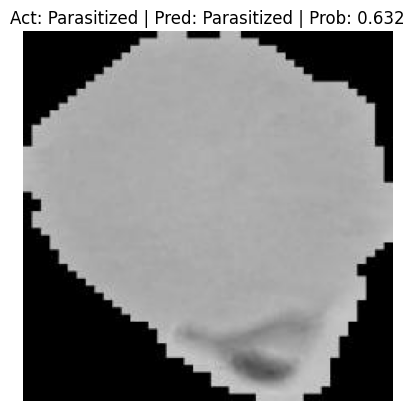

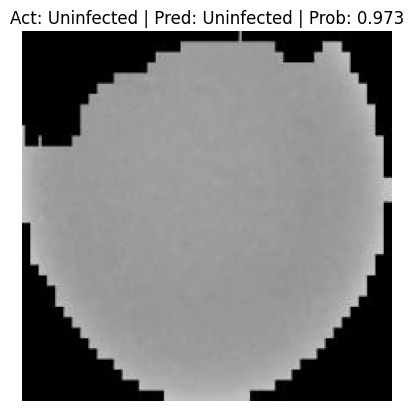

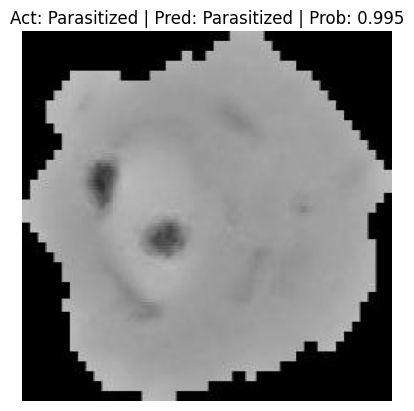

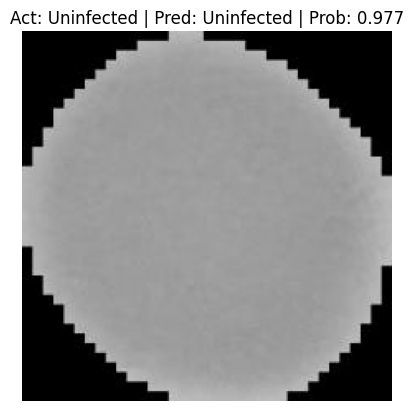

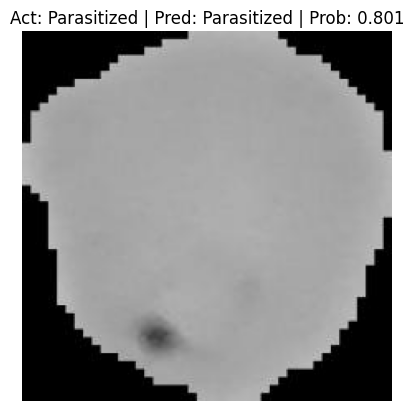

In [122]:
import random 
# Get a random list of image paths from the test set
num_images_to_plot = 5

test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model= model,
                      image_path= image_path,
                      class_names=class_names,
                      transform=transform,
                      image_size=(224,224))

## Training the model on the actual data

In [60]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

image_path = root / "Real"
# Get amount of cores you cpu can use
NUM_WORKERS = os.cpu_count()

# Create Transforms for model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    normalize
])

# Create dataloaders

# Directories
train_dir = image_path / "train"
test_dir = image_path / "test" 

# Datasets
train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

# get Class names
class_names = train_data.classes

# Create Dataloaders
train_dataloader = DataLoader(
    train_data,
    batch_size=32, # 32 because 32 is a good number for batches
    shuffle=True, # induces randomness
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_dataloader = DataLoader(
    test_data,
    batch_size=32, # 32 because 32 is a good number for batches
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(len(train_data), len(test_data))


In [61]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

for params in model.features.parameters():
    params.requires_grad = False
    
# Update the classifier to fit our problem
from torch import nn
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

In [62]:
# create loss functions and optimizers
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
results = train_model(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=10,
                      device=device)

 10%|█         | 1/10 [12:14<1:50:09, 734.44s/it]

Epoch: 1 | train_loss: 0.2951 | train_acc: 0.8828 | test_loss: 0.2263 | test_acc: 0.9057


 20%|██        | 2/10 [23:52<1:35:05, 713.13s/it]

Epoch: 2 | train_loss: 0.2437 | train_acc: 0.9054 | test_loss: 0.2171 | test_acc: 0.9163


 30%|███       | 3/10 [35:18<1:21:45, 700.82s/it]

Epoch: 3 | train_loss: 0.2466 | train_acc: 0.9054 | test_loss: 0.2246 | test_acc: 0.9054


 40%|████      | 4/10 [46:41<1:09:22, 693.67s/it]

Epoch: 4 | train_loss: 0.2341 | train_acc: 0.9061 | test_loss: 0.2058 | test_acc: 0.9304


 50%|█████     | 5/10 [58:12<57:42, 692.59s/it]  

Epoch: 5 | train_loss: 0.2387 | train_acc: 0.9043 | test_loss: 0.2148 | test_acc: 0.9101


 60%|██████    | 6/10 [1:09:43<46:08, 692.14s/it]

Epoch: 6 | train_loss: 0.2373 | train_acc: 0.9075 | test_loss: 0.2038 | test_acc: 0.9163


 70%|███████   | 7/10 [1:21:36<34:57, 699.03s/it]

Epoch: 7 | train_loss: 0.2376 | train_acc: 0.9090 | test_loss: 0.2033 | test_acc: 0.9194


 80%|████████  | 8/10 [1:33:20<23:21, 700.66s/it]

Epoch: 8 | train_loss: 0.2364 | train_acc: 0.9060 | test_loss: 0.2134 | test_acc: 0.9128


 90%|█████████ | 9/10 [1:44:49<11:36, 696.90s/it]

Epoch: 9 | train_loss: 0.2364 | train_acc: 0.9088 | test_loss: 0.2051 | test_acc: 0.9175


100%|██████████| 10/10 [1:56:18<00:00, 697.89s/it]

Epoch: 10 | train_loss: 0.2312 | train_acc: 0.9113 | test_loss: 0.2143 | test_acc: 0.9175


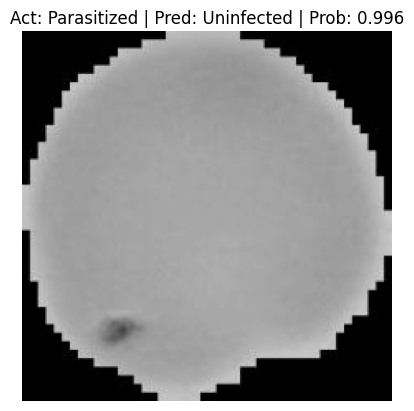

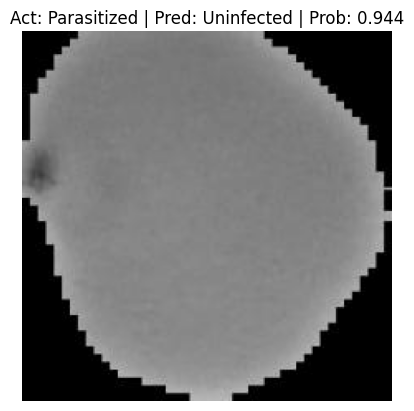

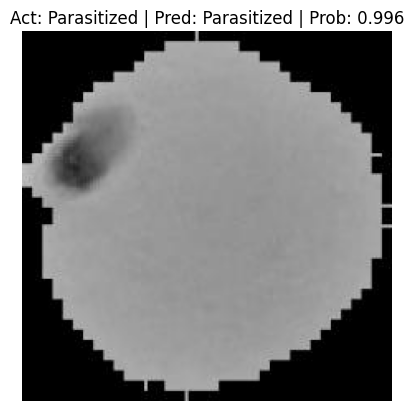

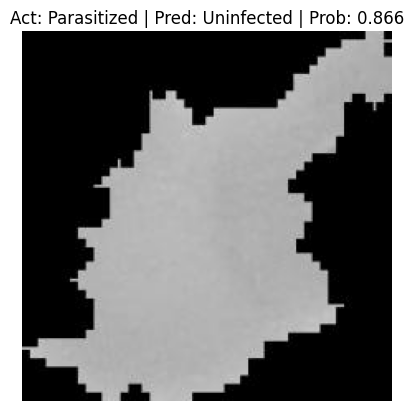

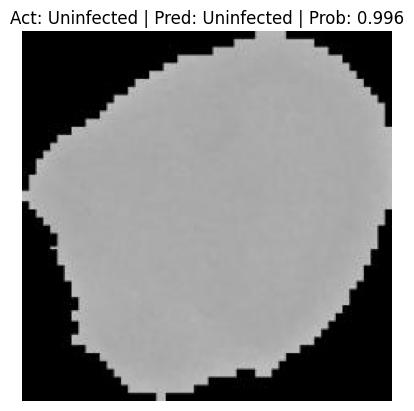

In [71]:
import random 
# Get a random list of image paths from the test set
num_images_to_plot = 5

test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model= model,
                      image_path= image_path,
                      class_names=class_names,
                      transform=transform,
                      image_size=(224,224))